## Смоделировать динамику LIF-нейрона. Реализовать модель нейрона с утечкой и интеграцией (Leaky Integrate-and-Fire), изучить его реакцию на различные входные токи.

In [1717]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Callable
import random
import uuid

@dataclass
class LIFNeuron:
    tau_m: float = 20.0
    v_rest: float = -70.0
    v_thresh: float = -55.0
    v_reset: float = -75.0
    r_m: float = 15.0
    tau_ref: float = 5.0
    id: int = 0

    def __post_init__(self):
        self.v = self.v_rest
        self.refractory_until = 0.0
        self.spike_times = []
        self.v_trace = []

    def reset(self):
        self.v = self.v_rest
        self.refractory_until = 0.0
        self.spike_times = []
        self.v_trace = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        if t < self.refractory_until:
            self.v = self.v_reset
            self.v_trace.append(self.v)
            return False

        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt
        
        # ✅ Проверяем спайк
        if self.v >= self.v_thresh:
            self.v_trace.append(self.v_thresh)  # ✅ Сохраняем ПОРОГ (-55 мВ)
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        else:
            self.v_trace.append(self.v)  # Обычное значение
            return False

def simulate_neuron(neuron: LIFNeuron, I_func: Callable[[float], float], 
                   T: float, dt: float) -> tuple:
    """
    Универсальная симуляция.
    I_func(t) — функция, возвращающая ток в момент времени t.
    """
    t_range = np.arange(0, T, dt)
    v_trace = []
    I_trace = []
    
    for t in t_range:
        I = I_func(t)
        neuron.step(I, dt, t)
        v_trace.append(neuron.v)
        I_trace.append(I)
    
    return t_range, np.array(v_trace), np.array(I_trace), neuron.spike_times

In [1718]:
# Фабрика функций входного тока
def make_step_current(I_on: float, t_start: float, t_end: float):
    return lambda t: I_on if t_start <= t <= t_end else 0.0

def make_ramp_current(I_max: float, t_start: float, t_end: float):
    return lambda t: I_max * (t - t_start) / (t_end - t_start) if t_start <= t <= t_end else 0.0

def make_sinusoidal_current(I_amp: float, freq_hz: float, I_offset: float = 0.0):
    return lambda t: I_offset + I_amp * np.sin(2 * np.pi * freq_hz * t / 1000.0)

def make_noisy_current(I_mean: float, noise_std: float):
    return lambda t: I_mean + np.random.normal(0, noise_std)

def make_pulse_train(I_amp: float, pulse_width: float, period: float):
    return lambda t: I_amp if (t % period) < pulse_width else 0.0

In [1719]:
def plot_detailed_response(t, v, I, spikes, title: str):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    
    ax1.plot(t, I, 'g-', label='I_inj')
    ax1.set_ylabel('Ток (нА)')
    ax1.grid(True)
    ax1.set_title(title)
    
    ax2.plot(t, v, 'b-', label='V_m')
    ax2.axhline(y=-55.0, color='r', linestyle='--', label='Порог')
    ax2.axhline(y=-70.0, color='gray', linestyle=':', label='Покой')
    ax2.set_ylabel('Потенциал (мВ)')
    ax2.legend()
    ax2.grid(True)
    
    if spikes:
        ax3.eventplot(spikes, colors='k', linewidths=2)
    ax3.set_ylabel('Спайки')
    ax3.set_yticks([])
    ax3.set_xlabel('Время (мс)')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

=== Эксперимент: Реакция на разные формы тока ===


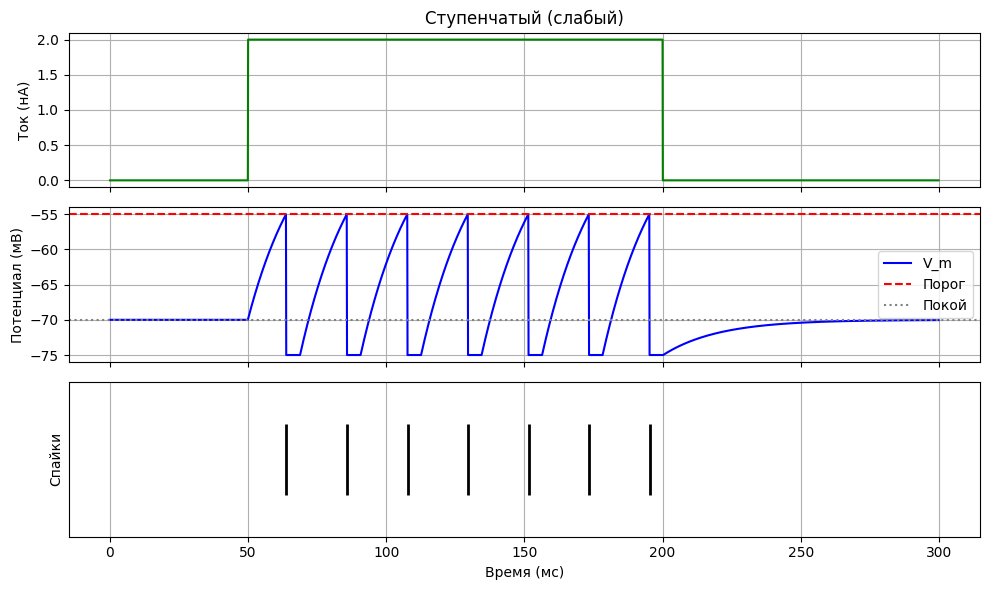

Ступенчатый (слабый): 7 спайков


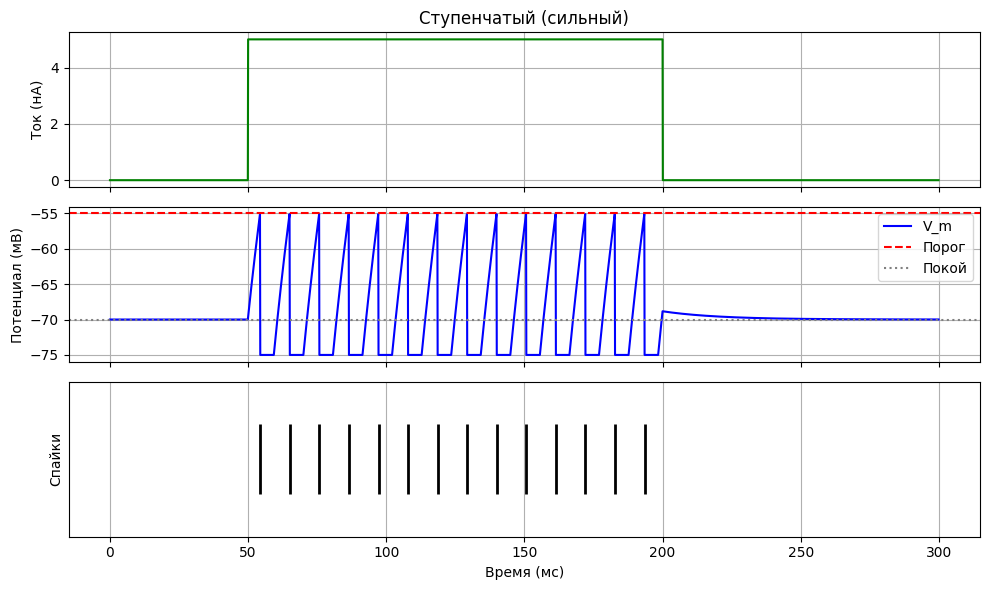

Ступенчатый (сильный): 14 спайков


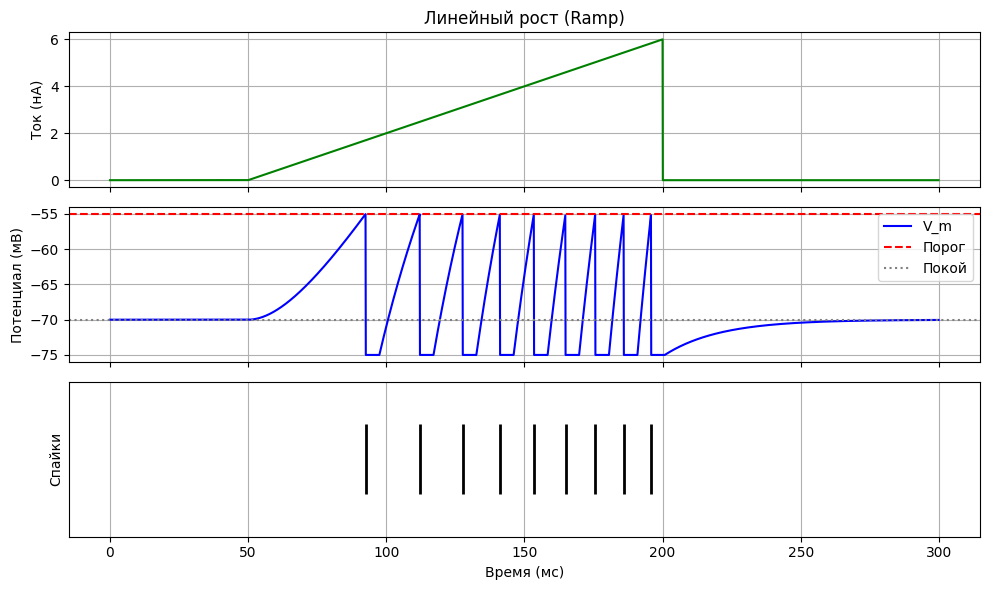

Линейный рост (Ramp): 9 спайков


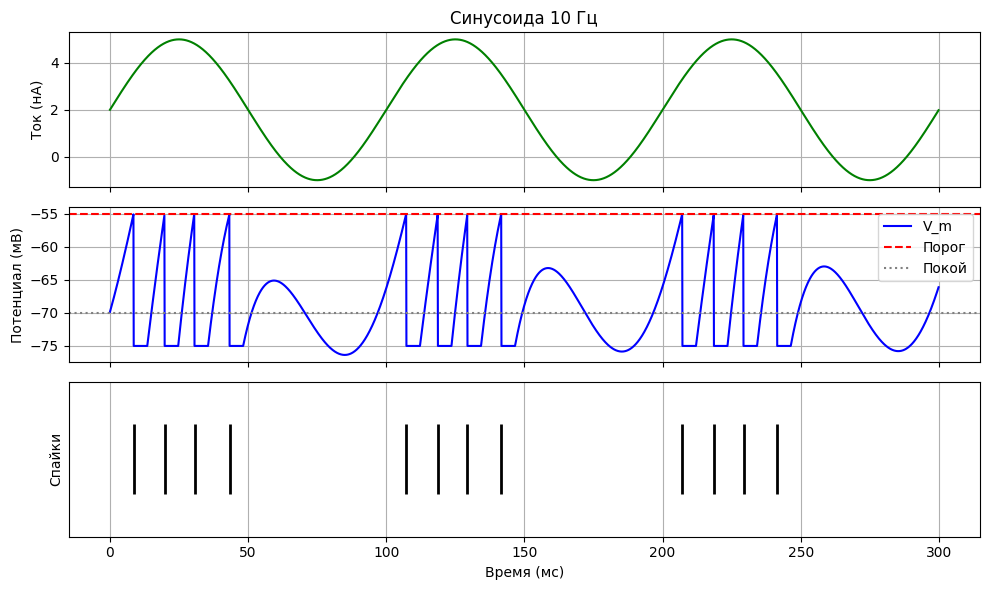

Синусоида 10 Гц: 12 спайков


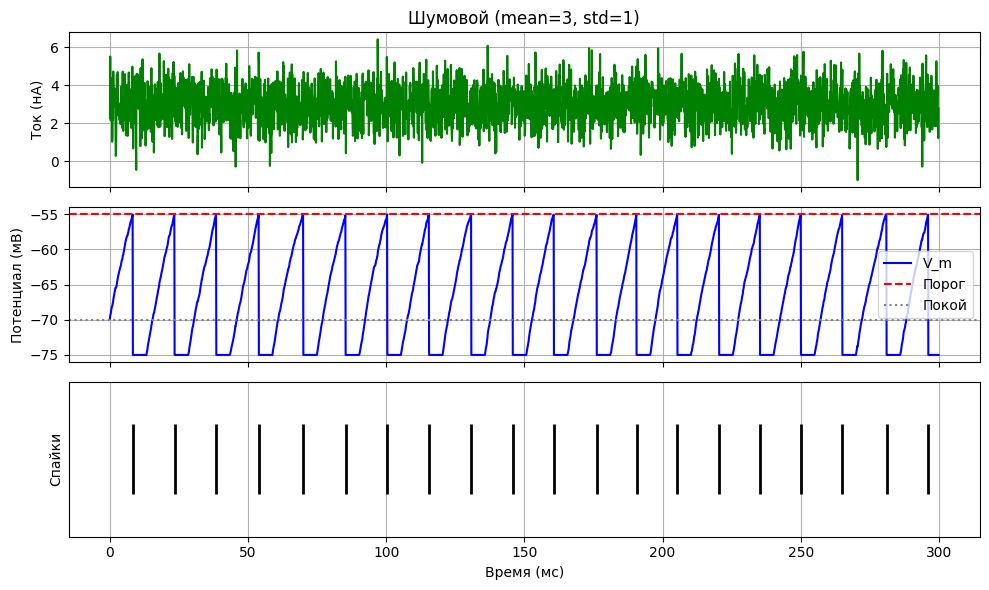

Шумовой (mean=3, std=1): 20 спайков


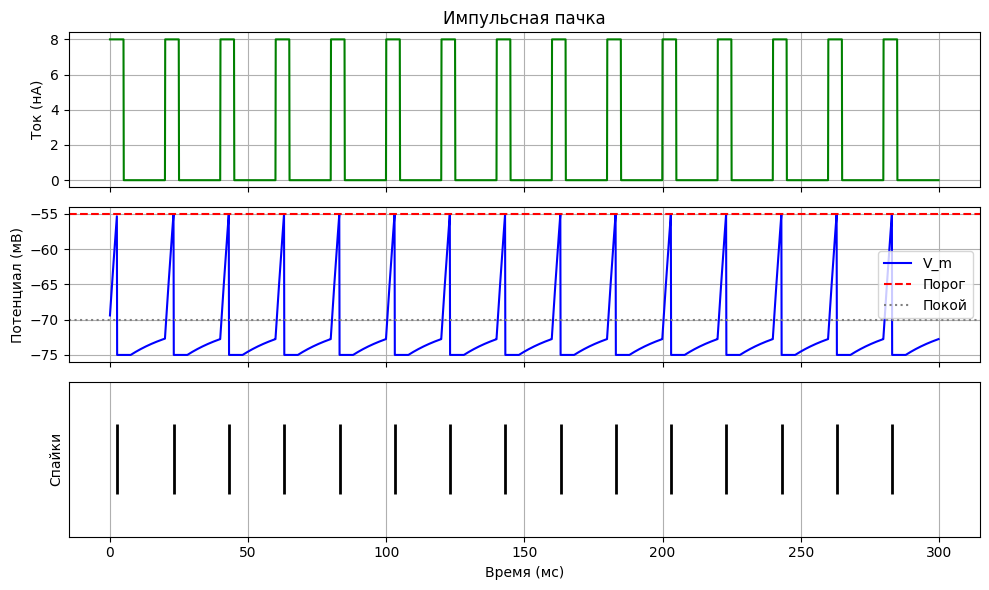

Импульсная пачка: 15 спайков


In [1720]:

print("=== Эксперимент: Реакция на разные формы тока ===")
dt, T = 0.1, 300

configs = [
    ("Ступенчатый (слабый)", make_step_current(2.0, 50, 200)),
    ("Ступенчатый (сильный)", make_step_current(5.0, 50, 200)),
    ("Линейный рост (Ramp)", make_ramp_current(6.0, 50, 200)),
    ("Синусоида 10 Гц", make_sinusoidal_current(3.0, 10, I_offset=2.0)),
    ("Шумовой (mean=3, std=1)", make_noisy_current(3.0, 1.0)),
    ("Импульсная пачка", make_pulse_train(8.0, pulse_width=5, period=20)),
]

for name, I_func in configs:
    neuron = LIFNeuron()
    t, v, I, spikes = simulate_neuron(neuron, I_func, T, dt)
    plot_detailed_response(t, v, I, spikes, name)
    print(f"{name}: {len(spikes)} спайков")

**Ступенчатый** - Регулярные спайки, частота зависит от амплитуды

**Линейный рост (Ramp)** - Задержка первого спайка, затем учащение

**Синусоида** - Фазовая привязка спайков

**Шумовой** - Стохастические спайки, вероятность растёт с I

**Импульсы** - Точное временное кодирование


=== Построение F-I кривой ===


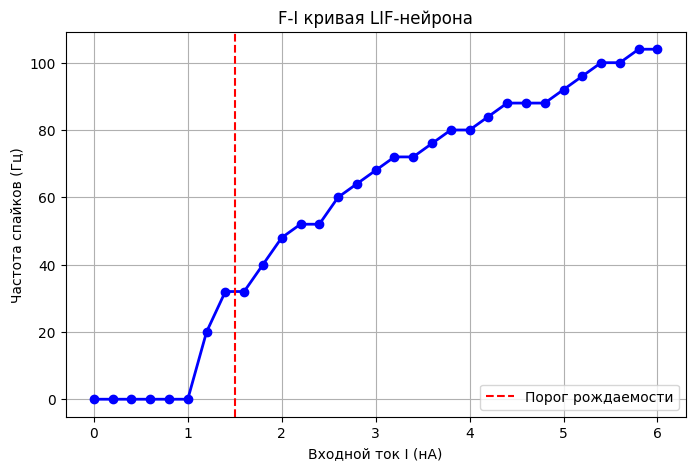


Анализ F-I кривой:
Реобаза: ~1.20 нА
Макс. частота при I=6 нА: 104.0 Гц


In [1721]:
def compute_firing_rate(spikes: List[float], T: float, skip_ms: float = 50.0) -> float:
    """Частота спайков в Гц, с исключением переходного процесса"""
    valid_spikes = [s for s in spikes if s > skip_ms]
    effective_T = (T - skip_ms) / 1000.0  # в секундах
    return len(valid_spikes) / effective_T if effective_T > 0 else 0.0

print("=== Построение F-I кривой ===")
I_values = np.arange(0.0, 6.1, 0.2)
rates = []
for I_amp in I_values:
    neuron = LIFNeuron()
    I_func = lambda t, I=I_amp: I  # постоянный ток
    t, v, I_trace, spikes = simulate_neuron(neuron, I_func, T, dt)
    rate = compute_firing_rate(spikes, T)
    rates.append(rate)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(I_values, rates, 'bo-', linewidth=2)
plt.axvline(x=1.5, color='r', linestyle='--', label='Порог рождаемости')
plt.xlabel('Входной ток I (нА)')
plt.ylabel('Частота спайков (Гц)')
plt.title('F-I кривая LIF-нейрона')
plt.grid(True)
plt.legend()
plt.show()

# Анализ
threshold_I = next((I for I, r in zip(I_values, rates) if r > 1.0), None)
print(f"\nАнализ F-I кривой:")
print(f"Реобаза: ~{threshold_I:.2f} нА")
print(f"Макс. частота при I=6 нА: {rates[-1]:.1f} Гц")

## Создать и проанализировать сеть из LIF-нейронов. Построить однослойную или двухслойную сеть, исследовать распространение спайковой активности.

In [1722]:
@dataclass
class SpikingSynapse:
    pre_id: int
    post_id: int
    weight: float = 0.5
    
    A_plus: float = 0.04
    A_minus: float = 0.03
    tau_plus: float = 20.0
    tau_minus: float = 20.0
    
    pre_trace: float = 0.0
    post_trace: float = 0.0
    
    eligibility_trace: float = 0.0
    tau_e: float = 300.0  # Было 50.0
    def update(self, pre_spike: bool, post_spike: bool, dt: float):
        self.pre_trace *= np.exp(-dt / self.tau_plus)
        self.post_trace *= np.exp(-dt / self.tau_minus)
        self.eligibility_trace *= np.exp(-dt / self.tau_e)
        if pre_spike:
            self.pre_trace += 1.0
            self.eligibility_trace += - self.A_minus * self.post_trace
        if post_spike:
            self.post_trace += 1.0
            self.eligibility_trace += self.A_plus * self.pre_trace

    def apply_reward(self, reward: float, lr: float):
        self.weight += lr * reward * self.eligibility_trace
        self.weight = np.clip(self.weight, 0.0, 3.0)


In [1723]:
class SimpleSNN:
    def __init__(self, n_input: int, n_output: int):
        self.n_input = n_input
        self.n_output = n_output
        # немного снизим разницу порогов
        self.output_neurons = [
            LIFNeuron(id=0, v_thresh=-55.0),
            LIFNeuron(id=1, v_thresh=-54.0)
        ]
        self.synapses = []
        for i in range(n_input):
            for j in range(n_output):
                # ВСЕ веса одинаково случайные!
                w = np.random.uniform(0.4, 0.6)  #或小范围随机
                self.synapses.append(SpikingSynapse(pre_id=i, post_id=j, weight=w))

    def get_synapses_to(self, post_idx: int) -> List[SpikingSynapse]:
        return [s for s in self.synapses if s.post_id==post_idx]

    def normalize(self):
        for j in range(self.n_output):
            syns = [s for s in self.synapses if s.post_id==j]
            total = sum(s.weight for s in syns)
            if total>0:
                scale = 5.0/total
                for s in syns:
                    s.weight *= scale

    def forward(self, input_spikes: np.ndarray, dt: float, t: float):
        output_spikes = []
        currents = []
        pre_spikes_list = []
        for j in range(self.n_output):
            I_syn = 0.0
            relevant_synapses = self.get_synapses_to(j)
            pre_spikes = []
            for syn in relevant_synapses:
                is_spike = bool(input_spikes[syn.pre_id])
                pre_spikes.append(is_spike)
                if is_spike:
                    I_syn += syn.weight * 10.0  # увеличим базовый ток
            pre_spikes_list.append(pre_spikes)
            currents.append(I_syn)
        
        winner = np.argmax(currents)
        for j in range(self.n_output):
            if j!=winner:
                currents[j] *= 0.2  # мягкое подавление вместо жесткого -5
        
        for j in range(self.n_output):
            spike = self.output_neurons[j].step(currents[j], dt, t)
            output_spikes.append(spike)

        for j in range(self.n_output):
            relevant_synapses = self.get_synapses_to(j)
            for idx, syn in enumerate(relevant_synapses):
                syn.update(pre_spikes_list[j][idx], output_spikes[j], dt)

        return output_spikes

    def learn(self, true_label: int, pred: int, lr: float):
        for syn in self.synapses:
            if syn.post_id == true_label:
                syn.apply_reward(+1.0, lr)
            elif syn.post_id == pred:
                syn.apply_reward(-1.0, lr)

    def reset(self):
        for n in self.output_neurons:
            n.reset()

In [1724]:
def make_pattern(label: int, t_range: np.ndarray, dt: float):
    n = 10
    spikes = np.zeros((len(t_range), n))
    # Класс 0: активны 0-4, Класс 1: активны 5-9
    active = [0,1,2,3,4] if label==0 else [5,6,7,8,9]
    
    for i in range(n):
        if i in active:
            # Активные нейроны: высокая частота (например, 200 Гц -> p=0.2)
            p = 200 * dt / 1000.0 
        else:
            # Неактивные нейроны: низкая частота (шум, например 10 Гц -> p=0.01)
            p = 10 * dt / 1000.0
            
        spikes[:, i] = (np.random.rand(len(t_range)) < p).astype(float)
    return spikes

In [1725]:
def make_noisy_pattern(label: int, t_range: np.ndarray, dt: float, noise_prob: float = 0.01):
    spikes = make_pattern(label, t_range, dt)
    noise = (np.random.rand(*spikes.shape) < noise_prob).astype(float)
    return np.clip(spikes + noise, 0, 1)

In [1726]:
dt = 1.0
T = 300
t_range = np.arange(0,T,dt)
n_epochs = 20

net = SimpleSNN(10,2)
acc_hist = []
spikes_hist = []

for epoch in range(n_epochs):
    net.reset()
    true_label = np.random.randint(0,2)
    inputs = make_pattern(true_label, t_range, dt)
    for i,t in enumerate(t_range):
        net.forward(inputs[i], dt, t)
    counts = [len(n.spike_times) for n in net.output_neurons]
    pred = np.argmax(counts)
    net.learn(true_label, pred, lr=0.1)
    net.normalize()
    acc_hist.append(pred==true_label)
    spikes_hist.append(counts)
    if epoch%1==0 or epoch==n_epochs-1:
        print(f"Эпоха {epoch:3d}: Класс {true_label}, Предсказание {pred}, "
              f"Спайки {counts}, Точность {np.mean(acc_hist[max(0,epoch-9):epoch+1]):.0%}")

Эпоха   0: Класс 0, Предсказание 1, Спайки [18, 26], Точность 0%
Эпоха   1: Класс 0, Предсказание 0, Спайки [31, 5], Точность 50%
Эпоха   2: Класс 0, Предсказание 0, Спайки [32, 5], Точность 67%
Эпоха   3: Класс 0, Предсказание 0, Спайки [33, 4], Точность 75%
Эпоха   4: Класс 1, Предсказание 1, Спайки [2, 27], Точность 80%
Эпоха   5: Класс 1, Предсказание 1, Спайки [3, 31], Точность 83%
Эпоха   6: Класс 0, Предсказание 0, Спайки [36, 3], Точность 86%
Эпоха   7: Класс 0, Предсказание 0, Спайки [37, 4], Точность 88%
Эпоха   8: Класс 0, Предсказание 0, Спайки [35, 3], Точность 89%
Эпоха   9: Класс 1, Предсказание 1, Спайки [3, 30], Точность 90%
Эпоха  10: Класс 0, Предсказание 0, Спайки [36, 5], Точность 100%
Эпоха  11: Класс 0, Предсказание 0, Спайки [38, 2], Точность 100%
Эпоха  12: Класс 1, Предсказание 1, Спайки [0, 32], Точность 100%
Эпоха  13: Класс 0, Предсказание 0, Спайки [38, 4], Точность 100%
Эпоха  14: Класс 0, Предсказание 0, Спайки [37, 3], Точность 100%
Эпоха  15: Класс 1, 


Финальная точность: 100.0%
Энергопотребление: 360.0 пДж

Веса синапсов:
  Нейрон 0: среднее 0.50, входы 0-4: 0.85, входы 5-9: 0.15
  Нейрон 1: среднее 0.50, входы 0-4: 0.26, входы 5-9: 0.74
Устойчивость сети к шуму: 100.0%


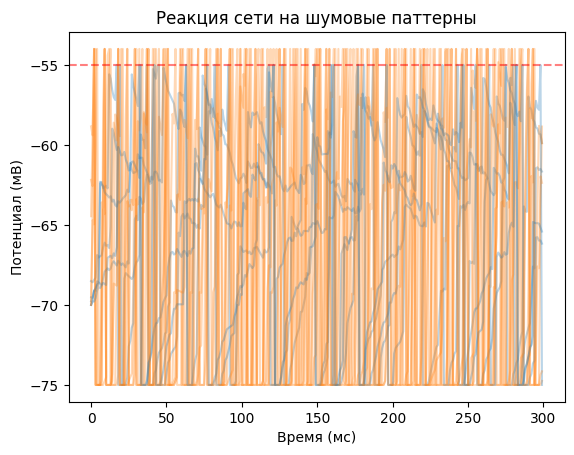

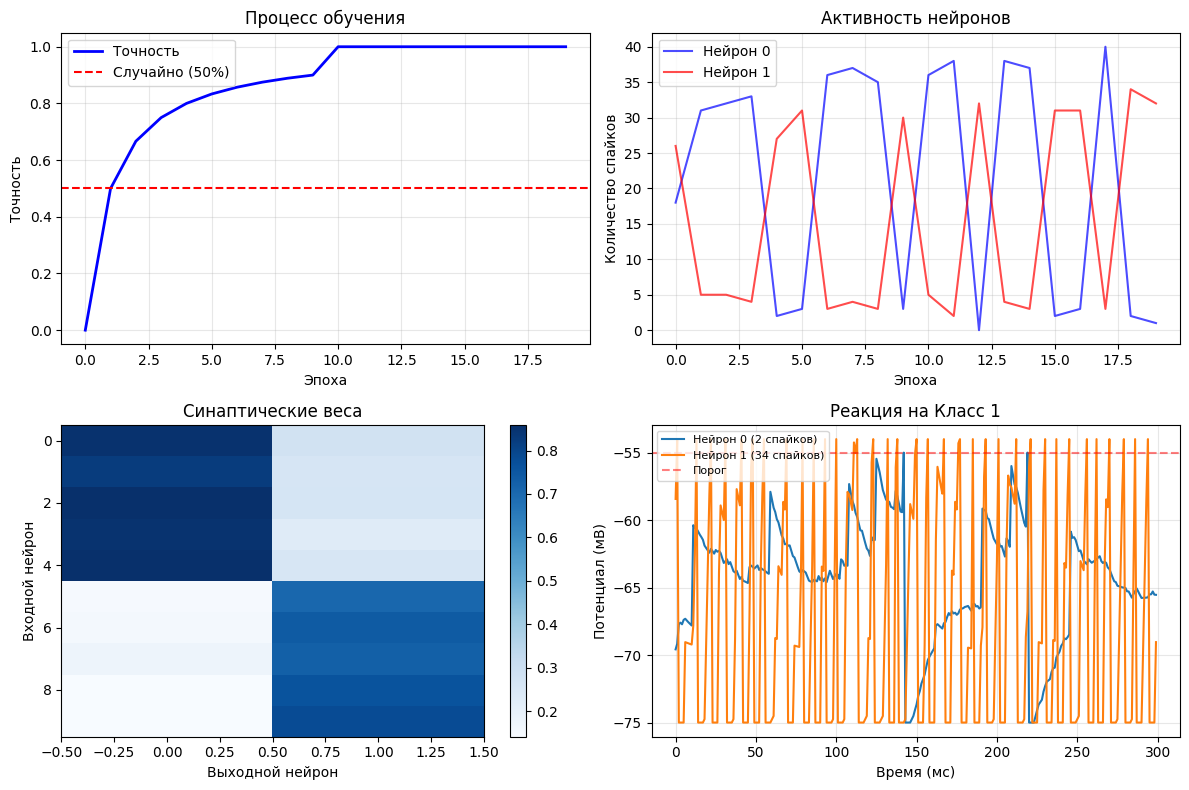


Финальная точность: 100.0%
Энергопотребление: 360.0 пДж

Веса синапсов:
  Нейрон 0: среднее 0.50, входы 0-4: 0.85, входы 5-9: 0.15
  Нейрон 1: среднее 0.50, входы 0-4: 0.26, входы 5-9: 0.74

✅ СЕТЬ НАУЧИЛАСЬ!


In [1728]:
import pandas as pd
print("\n" + "="*60)
final_acc = np.mean(acc_hist[-1:])
print(f"Финальная точность: {final_acc:.1%}")
total_spikes = sum(len(n.spike_times) for n in net.output_neurons)
print(f"Энергопотребление: {total_spikes * 10:.1f} пДж")

# Веса
print("\nВеса синапсов:")
for j in range(2):
    weights = [s.weight for s in net.synapses if s.post_id == j]
    print(f"  Нейрон {j}: среднее {np.mean(weights):.2f}, "
          f"входы 0-4: {np.mean(weights[:5]):.2f}, "
          f"входы 5-9: {np.mean(weights[5:]):.2f}")
print("="*60)


n_trials = 50
correct = 0
for _ in range(n_trials):
    test_input = make_noisy_pattern(test_label, t_range, dt, noise_prob=0.02)
    net.reset()
    for i, t in enumerate(t_range):
        net.forward(test_input[i], dt, t)
    counts = [len(n.spike_times) for n in net.output_neurons]
    pred = np.argmax(counts)
    if pred == test_label:
        correct += 1

print(f"Устойчивость сети к шуму: {correct/n_trials*100:.1f}%")


for trial in range(5):
    test_input = make_noisy_pattern(test_label, t_range, dt, noise_prob=0.02)
    net.reset()
    for i, t in enumerate(t_range):
        net.forward(test_input[i], dt, t)
    for j, neuron in enumerate(net.output_neurons):
        plt.plot(t_range, neuron.v_trace, alpha=0.3, color=f"C{j}")
plt.axhline(-55, color='r', linestyle='--', alpha=0.5)
plt.title("Реакция сети на шумовые паттерны")
plt.xlabel("Время (мс)")
plt.ylabel("Потенциал (мВ)")
plt.show()



# ----------------------- Графики -----------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Точность
acc = np.array(acc_hist)
moving = pd.Series(acc).rolling(window=10, min_periods=1).mean().values
axes[0, 0].plot(moving, 'b-', linewidth=2, label='Точность')
axes[0, 0].axhline(0.5, color='r', linestyle='--', label='Случайно (50%)')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Точность')
axes[0, 0].set_title('Процесс обучения')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Активность нейронов
spikes = np.array(spikes_hist)
axes[0, 1].plot(spikes[:, 0], 'b-', alpha=0.7, label='Нейрон 0')
axes[0, 1].plot(spikes[:, 1], 'r-', alpha=0.7, label='Нейрон 1')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Количество спайков')
axes[0, 1].set_title('Активность нейронов')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Синаптические веса
W = np.zeros((10,2))
for s in net.synapses:
    W[s.pre_id, s.post_id] = s.weight
im = axes[1, 0].imshow(W, cmap='Blues', aspect='auto')
axes[1, 0].set_xlabel('Выходной нейрон')
axes[1, 0].set_ylabel('Входной нейрон')
axes[1, 0].set_title('Синаптические веса')
plt.colorbar(im, ax=axes[1, 0])

# 4. Потенциалы нейронов на тестовом паттерне
net.reset()
test_label = 1
test_in = make_pattern(test_label, t_range, dt)

# Просто запускаем forward - v_trace заполняется внутри step()
for i, t in enumerate(t_range):
    spikes = net.forward(test_in[i], dt, t)

# ✅ Используем готовый v_trace из нейронов!
for j in range(2):
    axes[1, 1].plot(t_range, net.output_neurons[j].v_trace, 
                    label=f'Нейрон {j} ({len(net.output_neurons[j].spike_times)} спайков)')
axes[1, 1].axhline(-55, color='r', linestyle='--', alpha=0.5, label='Порог')
axes[1, 1].set_xlabel('Время (мс)')
axes[1, 1].set_ylabel('Потенциал (мВ)')
axes[1, 1].set_title(f'Реакция на Класс {test_label}')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Финальная точность и энергия
final_acc = np.mean(acc_hist[-1:])
total_spikes = sum(len(n.spike_times) for n in net.output_neurons)
print(f"\nФинальная точность: {final_acc*100:.1f}%")
print(f"Энергопотребление: {total_spikes*10:.1f} пДж\n")

# Веса синапсов
print("Веса синапсов:")
for j in range(2):
    weights = [s.weight for s in net.synapses if s.post_id==j]
    print(f"  Нейрон {j}: среднее {np.mean(weights):.2f}, "
          f"входы 0-4: {np.mean(weights[:5]):.2f}, "
          f"входы 5-9: {np.mean(weights[5:]):.2f}")

if final_acc > 0.95:
    print("\n✅ СЕТЬ НАУЧИЛАСЬ!")
else:
    print("\n⚠️ Точность недостаточна")